In [72]:
# Import Library
#%reset
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import keras
from glob import glob
from keras.preprocessing.image import ImageDataGenerator #, img_to_array, 
from tensorflow.keras.utils import img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
import os
import pickle
import warnings
warnings.filterwarnings("ignore")
from PIL import Image

#Usare scaler

# Prepare and Review Dataset

In [73]:
# Test and Train path
with open('newResa3.pickle', 'rb') as handle:
    newResa3 = pickle.load(handle)

with open('AllPixelBand3.pickle', 'rb') as handle:
    allPixel3 = pickle.load(handle)

# Identificare qualita' e suddivisione del dataset in maniera corretta tra train e test

 Low yield: 58 Medium yield[4500,10000]: 1472High yield(>10000): 31


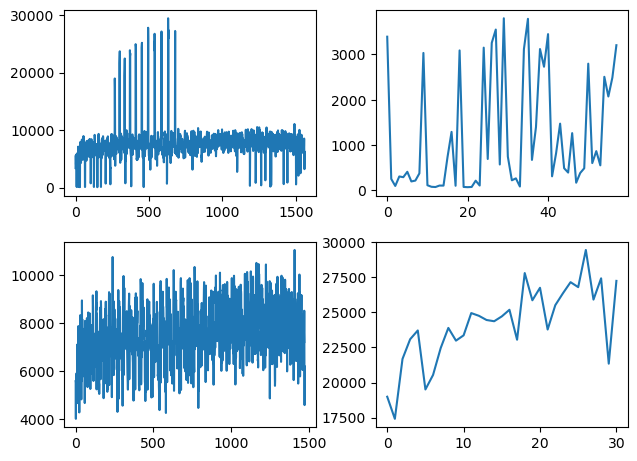

In [74]:
#taglio outliar
FilterResa3gtZero = newResa3!=0
newResa3 = newResa3[FilterResa3gtZero]
allPixel3 = allPixel3[FilterResa3gtZero,:,:]

LowValue = 1
Medium = 4000
HighValue = 12000
Resa3LowFilter = (newResa3<Medium) & (newResa3>LowValue)
Resa3MediumFilter = (newResa3>=Medium) & (newResa3<=HighValue)
Resa3HighFilter = (newResa3>HighValue)

Resa3Low = newResa3[Resa3LowFilter]
Resa3Medium = newResa3[Resa3MediumFilter]
Resa3High = newResa3[Resa3HighFilter]

Pixel3Low = allPixel3[Resa3LowFilter,:,:]
Pixel3Medium = allPixel3[Resa3MediumFilter,:,:]
Pixel3High = allPixel3[Resa3HighFilter,:,:]


print(" Low yield: "+str(len(Resa3Low))+ " Medium yield[4500,10000]: "+ str(len(Resa3Medium))+ "High yield(>10000): "+ str(len(Resa3High)))

padding = 1.2
f, axarr = plt.subplots(2,2)
f.tight_layout(pad=padding)
axarr[0][0].plot(newResa3)
axarr[0][1].plot(Resa3Low)
axarr[1][0].plot(Resa3Medium)
axarr[1][1].plot(Resa3High)
plt.show()

In [75]:
Resa3Medium = Resa3Medium/Resa3Medium.max()
Pixel3Medium = Pixel3Medium/Pixel3Medium.max()

# ideal yield

In [76]:
def ResaIdeale(ndviPicco,rumore):  
    ideale = ((ndviPicco**1.6)/2.3)+0.4
    return np.random.normal(loc=ideale, scale=rumore, size=None)

(1472, 12, 150)
(1472, 150)


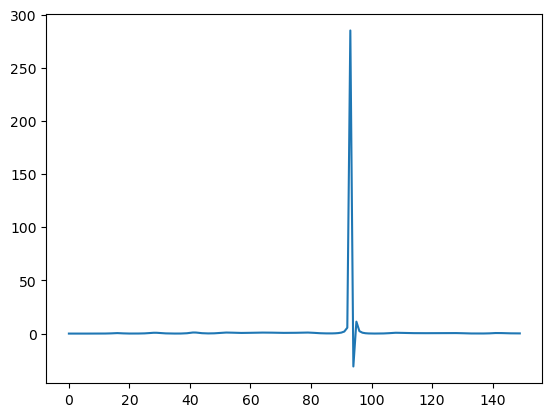

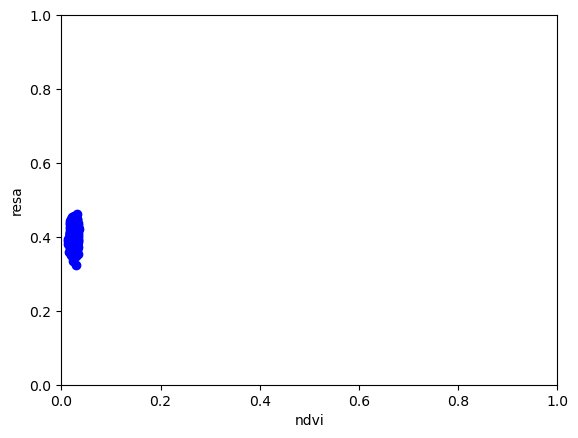

In [78]:
with open('ndvi.pickle', 'rb') as handle:
    NDVI3 = pickle.load(handle)

NDVI3Medium = (Pixel3Medium[:,7,:] - Pixel3Medium[:,3,:])/(Pixel3Medium[:,7,:] + Pixel3Medium[:,3,:])
print(Pixel3Medium.shape)
print(NDVI3Medium.shape)
referenceIndex = 20
Resa3MediumFake = []
noise = 0.02 #standard deviation
# noise a 0.1 is very similar to original dataset distribution
plt.plot(NDVI3Medium[1,:])
for v in (NDVI3Medium[:,referenceIndex]):
    Resa3MediumFake.append(ResaIdeale(v,noise))

Resa3MediumFake = np.array(Resa3MediumFake)
fig, ax = plt.subplots()
ax.scatter(NDVI3Medium[:,referenceIndex], Resa3MediumFake, c='blue')
ax.set_xlabel("ndvi")
ax.set_ylabel("resa")
ax.set_ylim([0,1])
ax.set_xlim([0,1])
plt.show()

# Split test set and train set

In [46]:
def splitSet(X,Y):
    if X.shape[0] != Y.shape[0]:
        raise Exception("X and Y have different sizes")
    choice = np.random.choice(range(X.shape[0]), size=(int(X.shape[0]/2),), replace=False)
    ind = np.zeros(X.shape[0], dtype=bool)
    ind[choice] = True
    rest = ~ind
    return np.array(X[ind,:,:]),np.array(Y[ind]),np.array(X[rest,:,:]),np.array(Y[rest])

[0.41483469 0.40902036 0.41208488 0.39902512 0.40155393 0.35995382
 0.41327227 0.39877489 0.40701666 0.41688633]


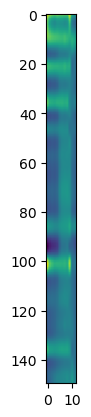

In [47]:
# Test and Train path
train_path = "dataset\\train\\"
test_path = "dataset\\test\\"

training_setMediumX,training_setMediumY, test_setMediumX, test_setMediumY = splitSet(Pixel3Medium,Resa3MediumFake)

training_setX = training_setMediumX
training_setY = training_setMediumY
test_setX = test_setMediumX
test_setY = test_setMediumY

print(training_setY[10:20])
plt.imshow(np.transpose(training_setX[0,:,:]))



In [48]:
print(training_setMediumX.shape)

(736, 12, 150)


# Image augmentation

In [49]:
def multiplyImg(img):
    newImg = np.concatenate((img,img,img,img,img,img),axis = 1)
    newImg = np.stack([newImg,newImg,newImg], axis=3)
    return newImg

In [50]:
print(training_setMediumX.shape)

(736, 12, 150)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(736, 72, 150, 3)
(72, 150)


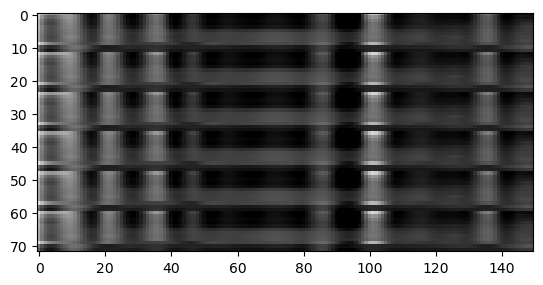

In [51]:

training_setMediumX = multiplyImg(training_setMediumX)
test_setMediumX = multiplyImg(test_setMediumX)
inputSize = training_setMediumX.shape[1:3]
print(training_setMediumX.shape)
print(inputSize)
plt.imshow(training_setMediumX[0])

# Creation of VGG16 model

In [52]:
# Import model
vgg16 = VGG16(input_shape=inputSize+(3,),include_top=False)


In [53]:
# add the layers of vgg16 in my created model.
vgg16Model = Sequential()
for i in range(len(vgg16.layers)-1):
    vgg16Model.add(vgg16.layers[i])


In [54]:
# Close the layers of vgg16
for layers in vgg16Model.layers:
    layers.trainable = False

In [55]:

# Last layer
vgg16Model.add(Flatten())
vgg16Model.add(Dense(2048,activation='relu',name='fc1'))
vgg16Model.add(Dense(1024,activation='relu',name='fc2'))
vgg16Model.add(Dense(1,activation='linear'))

In [56]:
# After I added last layer in created model.
vgg16Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 72, 150, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 72, 150, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 36, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 36, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 36, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 18, 37, 256)       2

In [57]:
# I create compile part.
vgg16Model.compile(loss = "mean_squared_error",
             optimizer = 'adam',
             metrics = ["mse","mae"])

# Training Model 

In [58]:
# Traning with model
batch_size = 32
#training_setMediumY, test_setMediumX, test_setMediumY
hist_vgg16 = vgg16Model.fit(x=training_setMediumX,y=training_setMediumY,
                                epochs = 25,
                                validation_data=(test_setMediumX,test_setMediumY)
                                )

Epoch 1/25
23/23 [==============================] - 32s 1s/step - loss: 71.7913 - mse: 71.7913 - mae: 3.6483 - val_loss: 0.5821 - val_mse: 0.5821 - val_mae: 0.7617
Epoch 2/25
23/23 [==============================] - 32s 1s/step - loss: 0.2916 - mse: 0.2916 - mae: 0.4625 - val_loss: 0.0582 - val_mse: 0.0582 - val_mae: 0.2394
Epoch 3/25
21/23 [==========================>...] - ETA: 1s - loss: 0.0261 - mse: 0.0261 - mae: 0.1371

KeyboardInterrupt: 

# Plot the result of the network

In [ ]:
true_y = Resa3MediumFake
print(len(true_y))
pred_y = vgg16Model.predict(test_setMediumX)

736
23/23 [==============================] - 13s 570ms/step


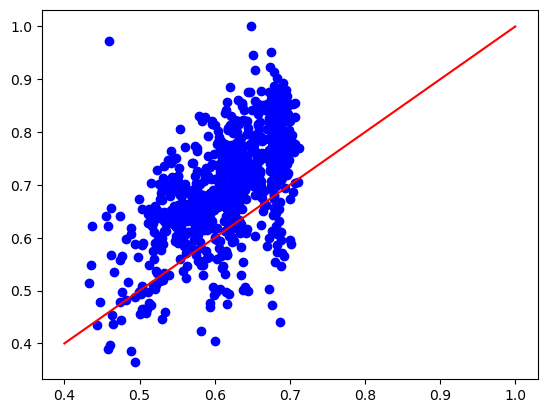

In [ ]:

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()
ax.scatter(pred_y, true_y, c='blue')
line = mlines.Line2D([0.4, 1], [0.4, 1], color='red')
transform = ax.transAxes
ax.add_line(line)
plt.show()


# training with bigger standard deviation

In [ ]:
Resa3MediumFake = []
noise = 0.05 #standard deviation
# noise a 0.1 is very similar to original dataset distribution

for v in (NVDI3Medium[:,12]):
    Resa3MediumFake.append(ResaIdeale(v,noise))

Resa3MediumFake = np.array(Resa3MediumFake)
fig, ax = plt.subplots()
ax.scatter(NVDI3Medium[:,12], Resa3MediumFake, c='blue')
ax.set_xlabel("ndvi")
ax.set_ylabel("resa")
ax.set_ylim([0,1])
ax.set_xlim([0,1])
plt.show()

In [ ]:
# Traning with model
batch_size = 32
#training_setMediumY, test_setMediumX, test_setMediumY
hist_vgg16 = vgg16Model.fit(x=training_setMediumX,y=training_setMediumY,
                                epochs = 25,
                                validation_data=(test_setMediumX,test_setMediumY)
                                )

# plot the result

In [ ]:
true_y = Resa3MediumFake
print(len(true_y))
pred_y = vgg16Model.predict(test_setMediumX)
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()
ax.scatter(pred_y, true_y, c='blue')
line = mlines.Line2D([0.4, 1], [0.4, 1], color='red')
transform = ax.transAxes
ax.add_line(line)
plt.show()